- Neste tutorial serão implementadas e descritas 3 redes neurais, a fim de classificar/codificar algumas letras do alfabeto hebraico (cursivo) 
1 Rede Neural de classificação Implementada através da biblioteca TensorFlow sem recorrer ao keras.
2 Rede Neural Convulucional para classificação de imagem recorrendo ao modelo sequencial do TF.keras.
3 Autoencoder das letras recorrendo ao modelo funcional do tf.keras. 

- Organização do dataset

O Dataset encontram-se organizados da seguinte forma. A pasta dados tem duas subpastas Treino e Teste.
Ambas as pastas (treino,teste) contêm 27 subpastas, cujo o nome é um numero entre 0 a 26, que corresponde a uma letra do 
alfabeto hebraico. Cada pasta numerada, tem ~ 140 exemplos (treino) ~ 45 exemplos (teste).
Como são 27 letras, para reduzir o tamanho do dataset e simplificar o treino, treinarei a rede para classificar 7 letras (alef,iud,lamed,mem sofit,ayn,raish,shin) correspondntes a עם ישראל

Assim, começarei por carregar os dados e formatar os mesmos no formato requerido para ser input de uma rede neural densa.
Esse input será um tensor 1d (correspondente aos pixeis 32*32 para cada imagem) com valores por pixeis correspondentes ao 
grayscale e normalizados entre 0-1. Os labels estarão em formato one-hot encoding, havendo 7 classes distintas.

In [1]:
# Importar Bibliotecas necessárias para a edificação da Rede Neural
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from datetime import datetime


2023-03-20 13:24:41.655051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 13:24:41.753185: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-20 13:24:42.145243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:
2023-03-20 13:24:42.145292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [7]:
# carregar, tranformar tamanho, normalizar dados

def carregar(path_treino,path_test):
    '''esta função recebe o caminho dos dados de treino e de teste
    como as imagens não têm o mesmo tamanho optei por tranformar o
    tamanho para 32*32 e de seguida normaliza-se os pixeis entre 0-1'''        
    # retirado de https://keras.io/api/data_loading/image/
    train_ds = tf.keras.utils.image_dataset_from_directory(path_treino,
                                                           labels="inferred",
                                                           label_mode="int",
                                                           color_mode="grayscale",
                                                           batch_size=None,
                                                           image_size=(32, 32),
                                                           shuffle=False,
                                                           interpolation="bilinear")
    test_ds = tf.keras.utils.image_dataset_from_directory(path_test,
                                                           labels="inferred",
                                                           label_mode="int",
                                                           color_mode="grayscale",
                                                           batch_size=None,
                                                           image_size=(32, 32),
                                                           shuffle=False,
                                                           interpolation="bilinear")   
    return train_ds,test_ds

# carregar ds já com resize para (32*32)
treino='data_hebrew/TRAIN'
teste='data_hebrew/TEST'

train_ds,test_ds=carregar(treino,teste)

def formatar(dataset_treino,dataset_test):
    '''esta função recebe um tf.dataset de imagens com label 
    retorna as imagens normalizadas em formato 1d e os labels
    em one-hot'''   
    #tranformar dataset em arrays 
    train_images= np.asarray(list(dataset_treino.map(lambda x, y: x)))
    train_labels = np.asarray(list(dataset_treino.map(lambda x, y: y)))
    test_images= np.asarray(list(dataset_test.map(lambda x, y: x)))
    test_labels=np.asarray(list(dataset_test.map(lambda x, y: y)))
    
    # normalizar valores dos pixeis
    train_images = train_images.astype("float32") / 255.0
    test_images = test_images.astype("float32") / 255.0 
    
    # tranformar 2d para 1d e labels em one-hot
    test_images = test_images.reshape(-1,32*32)
    test_labels = tf.keras.utils.to_categorical(test_labels)
    train_images = train_images.reshape(-1,32*32)
    train_labels = tf.keras.utils.to_categorical(train_labels)
    return (train_images,train_labels),(test_images,test_labels)

#DADOS TREINO/TEST PRONTOS PARA INICIAR O TREINO
(train_images,train_labels),(test_images,test_labels)=formatar(train_ds,test_ds) 

print('x_train:\t{}'.format(train_images.shape))
print('y_train:\t{}'.format(train_labels.shape))
print('x_test:\t{}'.format(test_images.shape))
print('y_test:\t{}'.format(test_labels.shape))

Found 1046 files belonging to 7 classes.
Found 286 files belonging to 7 classes.


2023-03-20 13:33:24.924096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


x_train:	(1046, 1024)
y_train:	(1046, 7)
x_test:	(286, 1024)
y_test:	(286, 7)


1. Edificação da Rede Neural com tensorflow
Nesta implementação decidi utilizar uma rede neural com duas camadas escondidas com 50 e 30 neuronios, respectivamente e uma camada final com 7 neuronios correspondentes a cada letra. 

Numa primeira fase será criada uma lista que corresponde ao pesos/bias entre as diferentes camadas, que basicamente definem a arquitectura da nossa rede. 
Para tal será definida uma funçõão criar_rede, com uma função auxiliar layer.
A função criar_rede receberá como input (entrada e layers). A entrada são os dados de treino formatados anterioremente.
as layers correspondem a uma lista cujo o seu comprimento define o numero de layers e o valor de cada celula o número de neurónios. De seguida serão criados os pesos e o bias entre as diferentes layers. inicialmente é tomado em consideração o input de entra (img 32*32=1024) e o numero de neuronios da primeira layer (50 neuronios). 
Utilizando a função layer iniciaremos os valores aleatórios entre [0,1] para os pesos e e zeros para o bias. a dimensão dos tensores criados está realicionada com a dimensao da layer de saida e entrada. assim as dimensões tomarao em consideração o numero variaveis (pixeis) , ou seja numero de colunas e o numero de neuronios da layer de chegada. a dimensao dos pesos sera uma matriz m*n (varaiveis*neuronios) o bias terá uma ligacao para cada neuronio de chegada e portanto será um vector (neuronios*1). o processo repete-se de forma iterativa, utilizando um ciclo for até à ultima camada, a cada iteração são alimentadas as listas designadas anteriormente. Esssas listas servirão para treinar o modelo depois.

Em suma, quando chamada a função serão criados os pesos para a rede neural 
1024 input -w1,b1- 50 neuronios -w2,b2- 30 neuronios -w3,b3- 7 neuronios.

Os pesos intermedios serao tensores com a seguinte dimensao:
w1  - (1024,50); b1 (50,1)
w2  - (50,30); b2(30,1)
w2  - (30,7); b2(7,1)

In [8]:
##### FUNÇÕES PARA CRIAR REDE NEURONAL E DE APOIO

def layer(inputs,neurons,layer_name):
    '''esta funcao recebe os inputs o numero de neuronios e 
    retorna um tensor de pesos. (weigths e bias)'''
    weights=tf.Variable(tf.random.normal((inputs.shape[1],neurons)))
    bias=tf.Variable(tf.zeros([neurons]))
    return weights,bias

 
def criar_rede(entrada,layers):
    '''esta funcao recebe os inputs X, e o numero de neuronios por layer 
    em formato lista ex. [2,,3,1] e retorna a rede (pesos)'''
    network = []
    variables = []
    previous = entrada
    for i,neurons in enumerate(layers):
        weights,bias=layer(previous,neurons,f'layer {i}')
        network.append((weights,bias))
        variables.extend((weights,bias))
        previous=weights
    return network,variables

#criar rede neural considerando um input 1d 32*32, 2 hidden layers com 50 e 30 neuronios respectivamente e 7 neuronios de saída
# que corrrespondem às letras a classificar.

#network é uma lista de listas que contem os pesos e bias entre as diferentes camadas. são inicializados 
# de forma aleatoria através da função layer (bias inicializa com zero).

network,variables=criar_rede(train_images,[50,30,7]) #criar rede


# weughts/bias entre entrada e primeira hidden
weights1,weights2,weights3=[],[],[]
bias1,bias2,bias3=[],[],[]

layer_control=1
for weights,bias in network:
    if layer_control==1:
        weights1=weights
        bias1=bias
        layer_control+=1
    elif layer_control==2:
        weights2=weights
        bias2=bias
        layer_control+=1
    elif layer_control==3:
        weights3=weights
        bias3=bias
        layer_control+=1

- Treino da Rede
Nesta etapa basicamente vamos fazer a progressão da rede, ou seja, fazer o somatorio das multiplicações entre os pesos e o valor do input para cada neuronio de chegada utilizando as operações basicas entre tensores 'add' e 'matmul' com posterior activação, operções que se repetem até ao fim da rede.
Após obter esses valores os mesmos são activados com a função nao linear 'relu', que evita problemas como vanishment gradients da sigmoid.
No final, como se trata de um problema de multiclass em que cada entrada só pode pertencer a uma unica classe, na camada  output utilizarei softmax pois pretendo ter como output a class que tem maior probabilidade.
De seguida será feita a actualização dos pesos através da back propagation. Este processo acontece de forma iterativa até o numero de epocas de treino ser atingido.
 
Nesta etapa, utilizei uma função run_it() para efectuar o treino da rede. 
A função run_it() recebe como input o numero de épocas de treino, tamanho dos batches, X_treino,Y_treino e o optimizador.
De seguida itera-se sobre o numero de epocas. a cada época os batches são "aleatorizados" por forma a evitar minimos locais e é efectuado o forward e backpropagation para todos eles.
Isto é feito com recurso ao Tape.gradient, que vai guardando as operações que ocorrem durante o forward e as suas derivadas, para à posterior conseguir fazer o backpropagation para actualizar os pesos. Assim, na função grad()
com o tape são efectuadas as operações para a frente através da função forward(), que retorna os logits (valores para cada neuronio final. De seguida é calculada o loss com recurso à tf.nn.softmax_cross_entropy_with_logits(y,X), fazendo de seugida a média.
A média (loss) e os pesos das diferentes camadas são dados como input à função tape.gradient(), que retorna os gradientes e são  tambem retornados na função grad os pesos utilizados.
Na função run()
Os gradientes e os pesos são dados ao optimizer.apply_gradients(zip(gradients, variables), afim de serem actualizados os pesos. (SGD com learning rate de 0.01), com o valor de 0.1 estava a saturar e os valores a caminhares para +inf.
A cada época é calculado o custo e a accuracy e impresso esse valor, é feito através da função forward(), que computa o logit e de seguida é computado o custo entre o Y obtido e o Y real através da softmax_cross_entropy_with_logits



In [9]:
# coloca a hora para diferenciar ficheiros no directorio
logdir = "logs/train_data/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# writer define a criação do ficheiro no directorio definido
writer = tf.summary.create_file_writer(logdir)

def forward(X):
    '''esta função recebe o input e faz as forward operacions
    através de operações basicas de multiplicação, soma e aactivacoes respectvas (relu nas hidden layer)
    se for na camada output devolve o valor da operação afim de ser usado depois para o calculo
    do custo e da previsão'''
    net = X
    layer_c = 0
    length=len(network)
    for i in range(length):
        if layer_c==0:
            with tf.name_scope(f'Layer_{layer_c}'):
                net = tf.add(tf.matmul(net, weights1), bias1,name='net')
                net = tf.nn.leaky_relu(net, name="relu")
                layer_c += 1
        elif layer_c==1:
            with tf.name_scope(f'Layer_{layer_c}'):
                net = tf.add(tf.matmul(net, weights2), bias2,name='net')
                net = tf.nn.leaky_relu(net, name="relu")
                layer_c += 1
        else:
            with tf.name_scope('output'):
                net = tf.add(tf.matmul(net, weights3), bias3,name='net')            
    return net

      
def predict_arg(X):
    '''esta função recebe as imagens e faz o forward afim de obter os valores dos neuronios output
    esses valores sao activados através da softmax e de seguida é verificado o argumento maximo (probabilide)
    o que nos dá a classe a que pertence a imagem'''
    net= forward(X)
    return tf.argmax(tf.nn.softmax(net), axis=1)

def compute_loss(X, y):
    '''esta função recebe o logit da operação forward, calculado atrravés da função forward
    e o label verdadeiro e calcula o custo'''
    loss = tf.nn.softmax_cross_entropy_with_logits(y,X)
    return tf.reduce_mean(loss)

def grad(X, y):
    ''' esta função recebe x e y e retorna os gradientes da superficie custo
    para os pesos definidos. para fazer o forward recorre à função definida anteriormente 
    como forward() e o calculo do custo é feito através da função compute_loss'''
    with tf.GradientTape() as tape:
        predicted = forward(X)
        loss_val = compute_loss(predicted,y)
    return tape.gradient(loss_val, [weights1, bias1, weights2, bias2,weights3,bias3] ),[weights1, bias1, weights2, bias2,weights3,bias3]

@tf.function
def create_graph(X,Y): #chama a função gradiente
    _=grad(X,Y)

def write_graph(X,Y,writer): #shows how we can save this trace to Tensorboard
    tf.summary.trace_on(graph=True)
    create_graph(tf.constant(X.astype(np.float32)),tf.constant(Y.astype(np.float32)))
    with writer.as_default():
        tf.summary.trace_export(name="trace",step=0)

writer_graph=write_graph(train_images,train_labels,writer)


def run_it(epochs,batch_size,X,Y,X_test,Y_test,optimizer):
    '''funcao recebe numero epocas, tamanho bacth, dados e optimizador 
    itera sobre as epocas. a cada epoca calcula o a função custo e actualiza os pesos
    utilizando backpropagation utilizando optimizador com learning rate=0.1
    nesta funçao são utlizadas funções auxiliares definidas anteriormente.'''
    weights_pred=[]
    loss_train,l_test,accuracy_test=[],[],[]
    batches_per_epoch = X.shape[0]//batch_size
    for epoch in range(epochs):
        shuffled = np.arange(len(Y))
        np.random.shuffle(shuffled)
        for batch_num in range(batches_per_epoch):
            start = batch_num*batch_size
            batch_xs = tf.constant(X[shuffled[start:start+batch_size],:].astype(np.float32))
            batch_ys = tf.constant(Y[shuffled[start:start+batch_size]].astype(np.float32))
            gradients,variables = grad(batch_xs, batch_ys)
            optimizer.apply_gradients(zip(gradients, variables))
        weights_pred.append(variables) 
        y_pred=forward(tf.constant(X.astype(np.float32)))
        loss = compute_loss(y_pred,Y).numpy()
        yt_pred=forward(tf.constant(X_test.astype(np.float32)))
        loss_test = compute_loss(yt_pred,Y_test)
        pred=predict_arg(X_test)
        acc=np.mean(np.argmax(Y_test,axis=1)==pred.numpy())
        loss_train.append(loss)
        l_test.append(loss_test)
        accuracy_test.append(acc)
        print(f"Epoch {epoch}, loss training {loss}, loss test {loss_test}, accuracy tes {acc}")
        with writer.as_default():
            tf.summary.scalar('Train loss', loss, step=epoch)
    idx=np.argmin(l_test) #obter index onde loss tes a minimo para escolher pesos
    print('epoca com melhor desempenho: ',idx)
    writer.close()
    return loss_train,l_test,accuracy_test,weights_pred[idx]
        
optimizer = tf.optimizers.SGD(learning_rate=0.01)
loss_train,l_test,accuracy_test,weights_pred=run_it(500,32,train_images,train_labels,test_images,test_labels,optimizer)

Epoch 0, loss training 11.897160530090332, loss test 15.26425552368164, accuracy tes 0.44755244755244755
Epoch 1, loss training 8.185829162597656, loss test 11.347404479980469, accuracy tes 0.5034965034965035
Epoch 2, loss training 9.978081703186035, loss test 13.912816047668457, accuracy tes 0.42657342657342656
Epoch 3, loss training 5.668272495269775, loss test 8.905596733093262, accuracy tes 0.493006993006993
Epoch 4, loss training 6.619062423706055, loss test 9.685604095458984, accuracy tes 0.5244755244755245
Epoch 5, loss training 4.235728740692139, loss test 6.404754638671875, accuracy tes 0.6118881118881119
Epoch 6, loss training 3.4744691848754883, loss test 5.9820380210876465, accuracy tes 0.5804195804195804
Epoch 7, loss training 5.381402969360352, loss test 8.240126609802246, accuracy tes 0.4965034965034965
Epoch 8, loss training 2.974937915802002, loss test 5.382718563079834, accuracy tes 0.5944055944055944
Epoch 9, loss training 2.523585081100464, loss test 4.8255419731140

Epoch 80, loss training 0.5274854898452759, loss test 2.804227590560913, accuracy tes 0.6888111888111889
Epoch 81, loss training 0.7006979584693909, loss test 3.108037233352661, accuracy tes 0.6748251748251748
Epoch 82, loss training 0.604033887386322, loss test 3.0712010860443115, accuracy tes 0.6748251748251748
Epoch 83, loss training 0.472201943397522, loss test 2.8350656032562256, accuracy tes 0.7062937062937062
Epoch 84, loss training 0.5294103026390076, loss test 2.9263756275177, accuracy tes 0.6818181818181818
Epoch 85, loss training 0.5402103066444397, loss test 2.916909694671631, accuracy tes 0.6818181818181818
Epoch 86, loss training 0.46328476071357727, loss test 2.843191385269165, accuracy tes 0.7097902097902098
Epoch 87, loss training 0.4458456039428711, loss test 2.882873296737671, accuracy tes 0.6853146853146853
Epoch 88, loss training 0.48219797015190125, loss test 2.863921880722046, accuracy tes 0.6958041958041958
Epoch 89, loss training 0.4701727032661438, loss test 2

Epoch 158, loss training 0.2768687307834625, loss test 2.8639848232269287, accuracy tes 0.6923076923076923
Epoch 159, loss training 0.26667582988739014, loss test 2.8649189472198486, accuracy tes 0.6818181818181818
Epoch 160, loss training 0.28983986377716064, loss test 2.7935118675231934, accuracy tes 0.6853146853146853
Epoch 161, loss training 0.30022040009498596, loss test 2.913029670715332, accuracy tes 0.6958041958041958
Epoch 162, loss training 0.2731539011001587, loss test 2.864013671875, accuracy tes 0.7097902097902098
Epoch 163, loss training 0.38972657918930054, loss test 2.874624729156494, accuracy tes 0.7132867132867133
Epoch 164, loss training 0.33732566237449646, loss test 2.97584867477417, accuracy tes 0.6888111888111889
Epoch 165, loss training 0.32103559374809265, loss test 2.8262581825256348, accuracy tes 0.6958041958041958
Epoch 166, loss training 0.31602880358695984, loss test 2.8671000003814697, accuracy tes 0.6923076923076923
Epoch 167, loss training 0.27065205574

Epoch 236, loss training 0.23537643253803253, loss test 2.9367835521698, accuracy tes 0.7097902097902098
Epoch 237, loss training 0.22804762423038483, loss test 2.9048948287963867, accuracy tes 0.6818181818181818
Epoch 238, loss training 0.20329813659191132, loss test 2.8993539810180664, accuracy tes 0.7202797202797203
Epoch 239, loss training 0.2190132737159729, loss test 2.8746042251586914, accuracy tes 0.7272727272727273
Epoch 240, loss training 0.2093108743429184, loss test 2.975980043411255, accuracy tes 0.6748251748251748
Epoch 241, loss training 0.18926148116588593, loss test 2.953234910964966, accuracy tes 0.7027972027972028
Epoch 242, loss training 0.18376663327217102, loss test 3.0124404430389404, accuracy tes 0.6993006993006993
Epoch 243, loss training 0.23976653814315796, loss test 2.889680862426758, accuracy tes 0.7027972027972028
Epoch 244, loss training 0.19879314303398132, loss test 2.8942439556121826, accuracy tes 0.6958041958041958
Epoch 245, loss training 0.181280463

Epoch 314, loss training 0.16046297550201416, loss test 3.205695867538452, accuracy tes 0.6923076923076923
Epoch 315, loss training 0.23261253535747528, loss test 3.345749855041504, accuracy tes 0.6783216783216783
Epoch 316, loss training 0.1403638869524002, loss test 3.041245460510254, accuracy tes 0.6888111888111889
Epoch 317, loss training 0.18017271161079407, loss test 3.2260537147521973, accuracy tes 0.6678321678321678
Epoch 318, loss training 0.13990606367588043, loss test 3.066807985305786, accuracy tes 0.7062937062937062
Epoch 319, loss training 0.15002480149269104, loss test 3.1237761974334717, accuracy tes 0.7097902097902098
Epoch 320, loss training 0.1303371787071228, loss test 3.100684881210327, accuracy tes 0.7027972027972028
Epoch 321, loss training 0.13051290810108185, loss test 3.0911946296691895, accuracy tes 0.7202797202797203
Epoch 322, loss training 0.12962466478347778, loss test 3.1103100776672363, accuracy tes 0.7027972027972028
Epoch 323, loss training 0.15330219

Epoch 392, loss training 0.14110474288463593, loss test 3.311155319213867, accuracy tes 0.7237762237762237
Epoch 393, loss training 0.12390787154436111, loss test 3.2920045852661133, accuracy tes 0.6993006993006993
Epoch 394, loss training 0.11468737572431564, loss test 3.3168342113494873, accuracy tes 0.6958041958041958
Epoch 395, loss training 0.10229717940092087, loss test 3.2759552001953125, accuracy tes 0.7027972027972028
Epoch 396, loss training 0.10139327496290207, loss test 3.3395185470581055, accuracy tes 0.7062937062937062
Epoch 397, loss training 0.10246114432811737, loss test 3.2727067470550537, accuracy tes 0.7167832167832168
Epoch 398, loss training 0.09449907392263412, loss test 3.287094831466675, accuracy tes 0.6993006993006993
Epoch 399, loss training 0.1008826419711113, loss test 3.2641985416412354, accuracy tes 0.7202797202797203
Epoch 400, loss training 0.0991036593914032, loss test 3.306828737258911, accuracy tes 0.7097902097902098
Epoch 401, loss training 0.093180

Epoch 470, loss training 0.07894880324602127, loss test 3.4713563919067383, accuracy tes 0.7167832167832168
Epoch 471, loss training 0.07954267412424088, loss test 3.3787176609039307, accuracy tes 0.7237762237762237
Epoch 472, loss training 0.074259452521801, loss test 3.4082956314086914, accuracy tes 0.7202797202797203
Epoch 473, loss training 0.0757596418261528, loss test 3.383232593536377, accuracy tes 0.7272727272727273
Epoch 474, loss training 0.07576961815357208, loss test 3.4359686374664307, accuracy tes 0.7202797202797203
Epoch 475, loss training 0.07935567200183868, loss test 3.433199405670166, accuracy tes 0.7202797202797203
Epoch 476, loss training 0.0820080041885376, loss test 3.452096462249756, accuracy tes 0.7202797202797203
Epoch 477, loss training 0.07711128890514374, loss test 3.407832145690918, accuracy tes 0.7272727272727273
Epoch 478, loss training 0.07728716731071472, loss test 3.4038729667663574, accuracy tes 0.7202797202797203
Epoch 479, loss training 0.083150178

- Plot loss train e test e accuracy de test 
Foi feito o plot das curvas de custo e da precisao no teste através da função definida como aval().
Pode verificar-se que é às 150 epocas que se atinge o melhor resultados no set test, pois a partir dí o custo no teste começã a aumentar o que indica que o modelo começa a aprender demasiado com os dados. é uma boa forma de decidir para o treino mais cedo e a colecta dos pesos para o nosso modelo de previsão deve ser no minimo da curva de perda do set de test.
De seguida utilizaremos esses pesos para prevermos algumas letras aleatórias do set test e vizualizar-mos às mesmas.

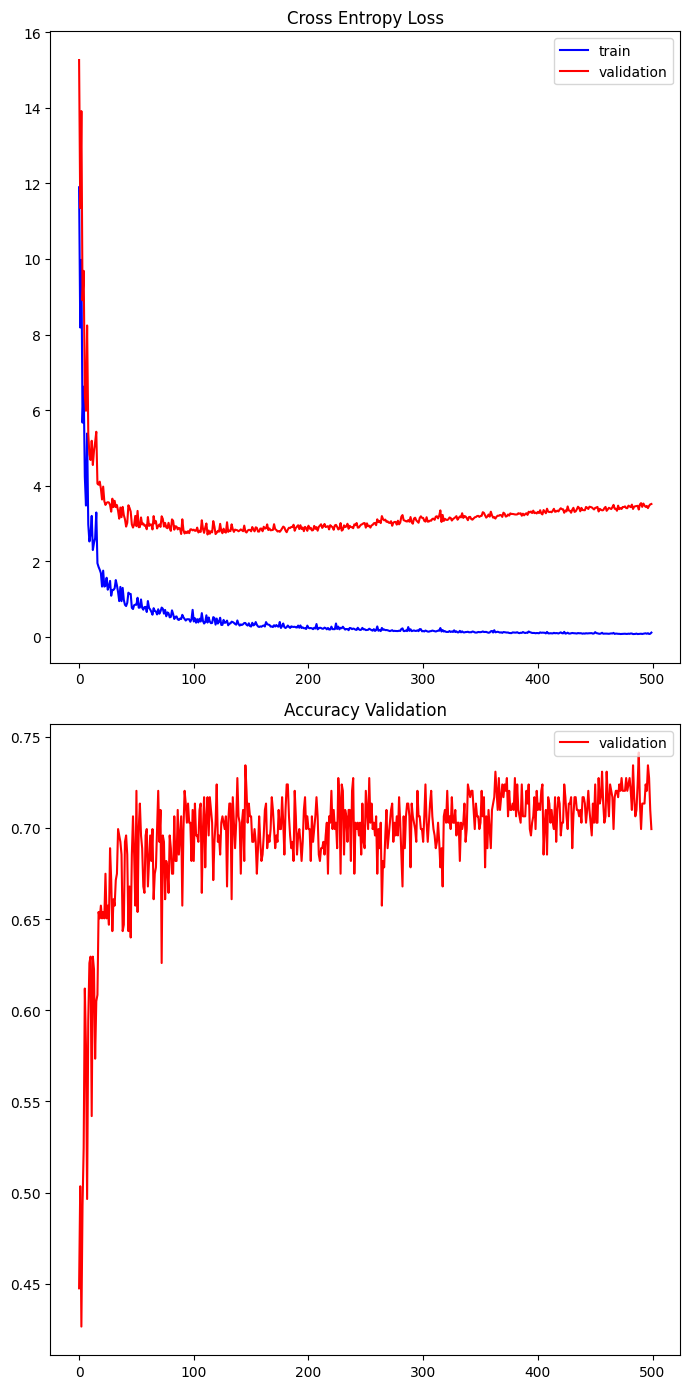

In [19]:
# plot diagnostico das curvas de loss e accuracy
def aval(l_train,l_test,accuracy_test,epochs):
    ''' esta função recebe os dados recolhidos no treino e as epochs para limentar o eixo x
    de segida são feitos 2 subplot, com a loss e a accuracy, respetivamente, de treino e teste'''
    epochs_array=np.arange(epochs)
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(epochs_array,l_train, color='blue', label='train')
    plt.plot(epochs_array,l_test, color='red', label='validation')
    plt.legend(loc="upper right")
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Accuracy Validation')
    plt.plot(epochs_array,accuracy_test, color='red', label='validation')
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

aval(loss_train,l_test,accuracy_test,500)

- Classificar letras com o modelo treinado anteriormente
Com a função  escolher() são escolhidos os 16 indices daleatoriamente das imagens do dataset test.
Na função plot prediction são impressas 16 letras com a previsão feita pela rede e com o label verdadeiro. a previsao é feita com funções definidas anteriormente, com uma ligeira alteração para os weights escolhidos após observar o treino. 
Verifica-se que uma rede densa para classificação de letras não é a melhor abordagem, pois não é sensivel à sua orientação e letras parecidas como é o caso do ayin, shin ou mem sofit, que se as rodarmos confundem-se facilmente são onde a rede mais falha. como é caso do b e p no alfabeto latino.

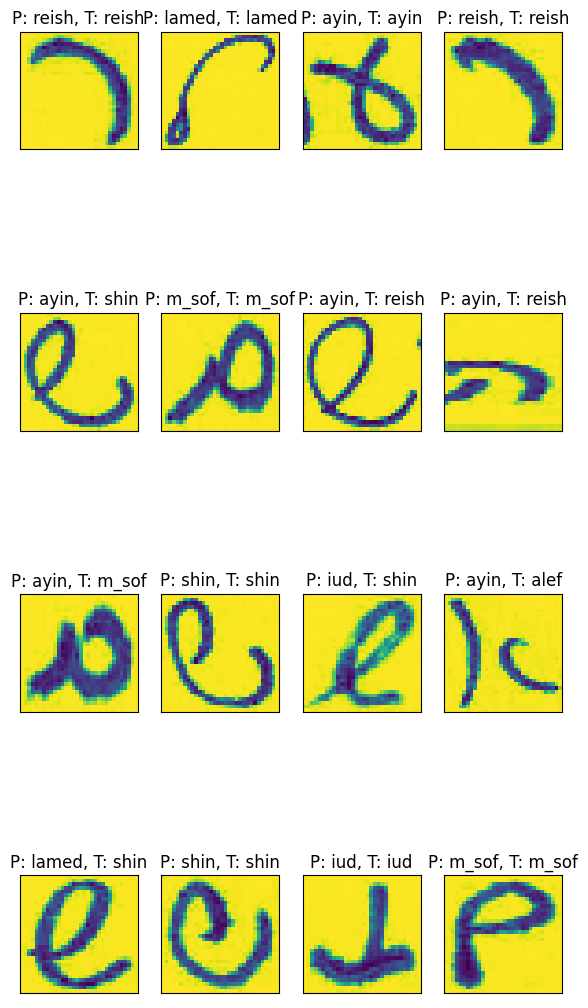

In [21]:

def forward_t(X,variaveis):
    '''esta função recebe o input e o network (contem pesos e bias) e faz as forward operacions
    através de operações basicas de multiplicação, soma e aactivacoes respectvas (relu nas hidden layer)
    se for na camada output devolve o valor da operação afim de ser usado depois para o calculo
    do custo e da previsão'''
    net = X
    layer_c = 0
    length=len(network)
    for i in range(length):
        if layer_c==0:
            net = tf.add(tf.matmul(net, variaveis[0]), variaveis[1],name='net')
            net = tf.nn.leaky_relu(net, name="relu")
            layer_c += 1
        elif layer_c==1:
            net = tf.add(tf.matmul(net, variaveis[2]), variaveis[3],name='net')
            net = tf.nn.leaky_relu(net, name="relu")
            layer_c += 1
        else:
            net = tf.add(tf.matmul(net, variaveis[4]), variaveis[5],name='net')            
    return net

def predict_arg_test(X,w):
    '''esta função recebe as imagens e faz o forward afim de obter os valores dos neuronios output
    esses valores sao activados através da softmax e de seguida é verificado o argumento maximo (probabilide)
    o que nos dá a classe a que pertence a imagem'''
    net= forward_t(X,w)
    return tf.argmax(tf.nn.softmax(net), axis=1)

def escolher(img):
    '''esta funcao recebe as img teste, verifica o numero de exemplares e é
    feito um random para escolher o indece para a escolha das imagens'''
    t_plot=np.random.choice(np.arange(img.shape[0]), 16,replace=False)
    return t_plot
                            
t_plot=escolher(test_images)
                          
def plot_predictions_ll(img,true_label,t_plot,w):
    c_names=['alef','lamed','m_sof','ayin','reish','shin','iud']
    y_test=np.argmax(true_label, axis=1)
    plt.rcParams['figure.figsize'] = (7,14)
    plt.figure()
    for i in range(t_plot.shape[0]):
        indice=t_plot[i]
        plt.subplot(4,4,i+1)
        plt.imshow(img[indice].reshape(32,32))
        pr_n=predict_arg_test(img[indice].reshape(1,1024),w)
        plt.title("P: {}, T: {}".format(c_names[pr_n.numpy()[0]],
                                        c_names[y_test[indice]]))
        plt.xticks([])
        plt.yticks([])    
    plt.show()
    
plot_predictions_ll(test_images,test_labels,t_plot,weights_pred)   
    

2. Implementação de CNN Rede neural convulucional utilizando Keras sequencial

Utilizamos o modelo sequencial quando pretendemos implementar uma rede onde cada camada tem exactamente um tensor como input e um tensor como output.
Neste caso, utilizaremos o modelo sequencial para implementar um cnn por forma a classificar o nosso Dataset.

Como a formatação de dados anteriores era do tipo um 1d, definiremos uma nova função (formatar_api), que recebe os set de treino e retornar as imagens e os labels, sendo que as imagens estarão em formato 2d (1 camada apenas de grayscale) no tamanho 32,32; e os seus labels em one_hot encoding. ficando em foramto (numero imagens,pixeis,pixeis,camadas)

In [22]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard
from numpy import argmax

# formatar dados: imagens em 2d, 1 camada; valores dos pixeis normalizadas 
def formatar_api(dataset_treino,dataset_test):
    '''esta função recebe um tf.dataset de imagens com label 
    retorna as imagens normalizadas em formato 2d e os labels
    em one-hot'''   
    #tranformar dataset em arrays 
    train_images= np.asarray(list(dataset_treino.map(lambda x, y: x)))
    train_labels = np.asarray(list(dataset_treino.map(lambda x, y: y)))
    test_images= np.asarray(list(dataset_test.map(lambda x, y: x)))
    test_labels=np.asarray(list(dataset_test.map(lambda x, y: y)))
    
    # normalizar valores dos pixeis
    train_images = train_images.astype("float32") / 255.0
    test_images = test_images.astype("float32") / 255.0 
    
    # tranformar 2d para 1d e labels em one-hot
    test_images = test_images.reshape((test_images.shape[0],32,32,1))
    test_labels = tf.keras.utils.to_categorical(test_labels)
    train_images = train_images.reshape((train_images.shape[0],32,32,1))
    train_labels = tf.keras.utils.to_categorical(train_labels)
    return train_images,train_labels,test_images,test_labels

#carregar dados formatados
train_img,train_label,test_img,test_label=formatar_api(train_ds,test_ds)

 - definição de modelo
 de seguida definiremos o modelo definindo a função model_ks(). O modelo será do tipo sequencial. adicionamos uma primeira operação convulucional de 32 filtros (3*3) sendo os seus valores inicializados considerando uma distribuição uniforme. Como tenciono perservar o tamanho do mapa de entrada utilizei padding=same. Neste caso particular poderia utilizar valid sem preocupação, pois a informação nos limites da imagem (letras cursivas) não é relevante. O stride por defeito é (1,1), ou seja, a cada operação dotproduct (soma das multiplicaçoes entre os valores do filtro e da area ocupada no mapa) será efectuado um miovimento de um pixel para a direita, o que acontecerá até ao limite do mapa input, e depois retorna ao lado esquerdo descendo um pixel (...).
 Após estas operações será feita a activação 'relu', que introduz a nao linearidade ao modelo e possibilita aprender mapa complexos, que ajudam a retirar caracteristicas.
 Depois da activação é efectuado o max-poling que permite reduzir o tamanho dos mapas de varaiveis 'convulucionadas' e ajuda tambem a prevenir o overfiting. O max-poling é uma operação semelhante ao conv, mas em vez da operação somados produtos, é escolhido o numero maximo dentro da janela, neste caso de tamanho (2,2).
 Caso se apliquem novas convuluções, estas terão uma abrangencia maior na imagem, pois se incialmente os filtros 3*3 só apanhariam 9 pixeis de informação de cada vezz agora tem uma maior abrangência porque a imagem foi reduzida. 
 
 Aplicamos uma nova convulução de 64 filtros ao input retornado pelo maxpoling (kwargs iguais) e seguida foi efectudo um novo maxpooling.
 Após esta operação o output foi tranformado em 1d através do flatten, input de uma rede densa.
Esse rede tem uma primeira layer de 100 neuronios de activação 'relu', uma layer de normalização do batch (normalização dos valores obtidos) que ajuda a estabilizar o modelo normalizando os valores de todos os neuronios é essecial no caso de utilizarmos sigmoid por forma a dificultar a saturação da rede, contudo usaremos relu e portanto apenas sá mais estabiliade e optimizaza a convergencia. 
Foi adicionado dropout de 1/2 probabilidade, por forma a evitar overfiting e de seguida colocada mais uma layer de 50 neuronios com dropout novamente.
Por fim, como estamos perante um proble,a de multiclass onde cada exemplo só pode pertencer a uma classe, foi adicionada uma camada final de 7 neuronios (correspondentes às classes a classificar) com uma activação softmax.
Foi utilizado um optimizador 'adam', em que o passo em direção ao minimo considera o histórico dos gradientes dando menos relevância aos mais antigos.
o modelo é compilado considerando o optimizador , loss do tipo categorico e entropia cruzada (multiclass classification) e métrica a ter em consideração é a precisão.

In [23]:
def model_ks():
    '''neste função é definida a arquitectura da rede neural de estrutura convulution+relu
    ,maxpooling,convulution+relu,maxpooling flatten. serão aplicados 32 filtros convulucionais
    3*3 activação Relu por forma a evitar vanishment gradients''' 
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu',padding="same", kernel_initializer='he_uniform', input_shape=(32, 32, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu',padding="same", kernel_initializer='he_uniform'))#kernel_regularizer =tf.keras.regularizers.l2( l=0.01)
    model.add(MaxPooling2D((2, 2)))
    #model.add(Conv2D(64, (3, 3), activation='relu',padding="same"))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))
	# compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#carregar dados formatados
train_img,train_label,test_img,test_label=formatar_api(train_ds,test_ds)

- treino do modelo
Após definido o modelo, a rede é treinada. Foi definida a função  run.
Essa função treina a rede considerando o tamanho do batch pre definido, neste caso 32, numero de epocas e os respectivos sets de treino e test. a cada época é dada uma loss e accuracy de treino e test.
O modelo (arquitectura, configuração e variaveis) é gravado em um ficheiro 'hebrew7_model.h5'.




In [24]:
#iniciar treino
def run(batch,epochs_n,train_img,train_label,test_img,test_label):
    '''esta função recebe os dataset treino, numero exemplos por batch e numero epocas
    de seguida carrega o modelo previamente definido. é cirado um directorio para gravar os callbaks do treino
    para serem mostrados previmente no tensorboard. de seguida o modelo é treinado considerando o input da funçao 
    run. é salvadoo os pesos e a arquitectura do modelo. a função retorna a loss e a accuracy treino e val'''
    model_k=model_ks()
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model_k.fit(train_img, train_label, validation_data=(test_img, test_label),batch_size=batch, epochs=epochs_n,callbacks=[tensorboard_callback])
    #_, acc = model_k.evaluate(test_img,test_label, verbose=0)
    model_k.save('hebrew7_model.h5')
    model_kjson = model_k.to_json()
    with open("hebrew7.json", "w") as json_file:
        json_file.write(model_kjson)
    return history

history=run(32,300,train_img,train_label,test_img,test_label)


Epoch 1/300
33/33 [==============================] - 1s 19ms/step - loss: 1.6432 - accuracy: 0.4293 - val_loss: 3.8373 - val_accuracy: 0.2413
Epoch 2/300
33/33 [==============================] - 1s 15ms/step - loss: 1.0231 - accuracy: 0.6377 - val_loss: 2.6548 - val_accuracy: 0.4126
Epoch 3/300
33/33 [==============================] - 1s 16ms/step - loss: 0.7515 - accuracy: 0.7467 - val_loss: 1.0004 - val_accuracy: 0.6888
Epoch 4/300
33/33 [==============================] - 0s 15ms/step - loss: 0.6327 - accuracy: 0.7983 - val_loss: 2.3274 - val_accuracy: 0.3951
Epoch 5/300
33/33 [==============================] - 0s 15ms/step - loss: 0.5432 - accuracy: 0.8403 - val_loss: 0.9299 - val_accuracy: 0.7203
Epoch 6/300
33/33 [==============================] - 0s 15ms/step - loss: 0.5211 - accuracy: 0.8499 - val_loss: 1.1473 - val_accuracy: 0.6469
Epoch 7/300
33/33 [==============================] - 0s 15ms/step - loss: 0.4581 - accuracy: 0.8681 - val_loss: 0.7447 - val_accuracy: 0.7587
Epoch 

33/33 [==============================] - 1s 16ms/step - loss: 0.0588 - accuracy: 0.9837 - val_loss: 1.0476 - val_accuracy: 0.7203
Epoch 59/300
33/33 [==============================] - 1s 15ms/step - loss: 0.0695 - accuracy: 0.9790 - val_loss: 1.1355 - val_accuracy: 0.7413
Epoch 60/300
33/33 [==============================] - 1s 15ms/step - loss: 0.0458 - accuracy: 0.9866 - val_loss: 0.9169 - val_accuracy: 0.7937
Epoch 61/300
33/33 [==============================] - 0s 15ms/step - loss: 0.0557 - accuracy: 0.9818 - val_loss: 0.5440 - val_accuracy: 0.8951
Epoch 62/300
33/33 [==============================] - 0s 15ms/step - loss: 0.0373 - accuracy: 0.9924 - val_loss: 0.5423 - val_accuracy: 0.9056
Epoch 63/300
33/33 [==============================] - 0s 15ms/step - loss: 0.0539 - accuracy: 0.9857 - val_loss: 0.5700 - val_accuracy: 0.9021
Epoch 64/300
33/33 [==============================] - 0s 15ms/step - loss: 0.0342 - accuracy: 0.9914 - val_loss: 0.6857 - val_accuracy: 0.8531
Epoch 65/300

33/33 [==============================] - 0s 15ms/step - loss: 0.0332 - accuracy: 0.9895 - val_loss: 0.7916 - val_accuracy: 0.8776
Epoch 116/300
33/33 [==============================] - 0s 15ms/step - loss: 0.0288 - accuracy: 0.9885 - val_loss: 1.9446 - val_accuracy: 0.6853
Epoch 117/300
33/33 [==============================] - 0s 15ms/step - loss: 0.0244 - accuracy: 0.9933 - val_loss: 1.4562 - val_accuracy: 0.7657
Epoch 118/300
33/33 [==============================] - 0s 15ms/step - loss: 0.0174 - accuracy: 0.9952 - val_loss: 1.5319 - val_accuracy: 0.7762
Epoch 119/300
33/33 [==============================] - 0s 15ms/step - loss: 0.0324 - accuracy: 0.9837 - val_loss: 0.8718 - val_accuracy: 0.8671
Epoch 120/300
33/33 [==============================] - 0s 15ms/step - loss: 0.0152 - accuracy: 0.9943 - val_loss: 1.2723 - val_accuracy: 0.8112
Epoch 121/300
33/33 [==============================] - 0s 15ms/step - loss: 0.0201 - accuracy: 0.9943 - val_loss: 1.5042 - val_accuracy: 0.7448
Epoch 

Epoch 172/300
33/33 [==============================] - 0s 15ms/step - loss: 0.0148 - accuracy: 0.9924 - val_loss: 0.8532 - val_accuracy: 0.8846
Epoch 173/300
33/33 [==============================] - 0s 15ms/step - loss: 0.0182 - accuracy: 0.9943 - val_loss: 0.9379 - val_accuracy: 0.8741
Epoch 174/300
33/33 [==============================] - 0s 15ms/step - loss: 0.0121 - accuracy: 0.9962 - val_loss: 1.1691 - val_accuracy: 0.8392
Epoch 175/300
33/33 [==============================] - 1s 15ms/step - loss: 0.0287 - accuracy: 0.9933 - val_loss: 0.9194 - val_accuracy: 0.8776
Epoch 176/300
33/33 [==============================] - 1s 15ms/step - loss: 0.0247 - accuracy: 0.9943 - val_loss: 0.8250 - val_accuracy: 0.8881
Epoch 177/300
33/33 [==============================] - 0s 15ms/step - loss: 0.0162 - accuracy: 0.9933 - val_loss: 1.2434 - val_accuracy: 0.8182
Epoch 178/300
33/33 [==============================] - 1s 15ms/step - loss: 0.0141 - accuracy: 0.9962 - val_loss: 1.2181 - val_accuracy:

Epoch 229/300
33/33 [==============================] - 1s 16ms/step - loss: 0.0173 - accuracy: 0.9914 - val_loss: 1.3984 - val_accuracy: 0.8287
Epoch 230/300
33/33 [==============================] - 1s 16ms/step - loss: 0.0254 - accuracy: 0.9904 - val_loss: 1.3337 - val_accuracy: 0.8497
Epoch 231/300
33/33 [==============================] - 1s 16ms/step - loss: 0.0206 - accuracy: 0.9933 - val_loss: 1.7214 - val_accuracy: 0.7762
Epoch 232/300
33/33 [==============================] - 1s 15ms/step - loss: 0.0112 - accuracy: 0.9971 - val_loss: 1.0036 - val_accuracy: 0.8462
Epoch 233/300
33/33 [==============================] - 1s 15ms/step - loss: 0.0173 - accuracy: 0.9952 - val_loss: 0.8854 - val_accuracy: 0.8706
Epoch 234/300
33/33 [==============================] - 1s 16ms/step - loss: 0.0146 - accuracy: 0.9952 - val_loss: 0.9964 - val_accuracy: 0.8636
Epoch 235/300
33/33 [==============================] - 1s 16ms/step - loss: 0.0227 - accuracy: 0.9904 - val_loss: 0.8866 - val_accuracy:

Epoch 286/300
33/33 [==============================] - 1s 16ms/step - loss: 0.0319 - accuracy: 0.9885 - val_loss: 0.9411 - val_accuracy: 0.8881
Epoch 287/300
33/33 [==============================] - 1s 15ms/step - loss: 0.0201 - accuracy: 0.9943 - val_loss: 0.9435 - val_accuracy: 0.8951
Epoch 288/300
33/33 [==============================] - 1s 16ms/step - loss: 0.0146 - accuracy: 0.9971 - val_loss: 0.8955 - val_accuracy: 0.9021
Epoch 289/300
33/33 [==============================] - 1s 16ms/step - loss: 0.0219 - accuracy: 0.9895 - val_loss: 0.8032 - val_accuracy: 0.8951
Epoch 290/300
33/33 [==============================] - 1s 16ms/step - loss: 0.0273 - accuracy: 0.9924 - val_loss: 0.8562 - val_accuracy: 0.8881
Epoch 291/300
33/33 [==============================] - 1s 16ms/step - loss: 0.0394 - accuracy: 0.9876 - val_loss: 0.8968 - val_accuracy: 0.8846
Epoch 292/300
33/33 [==============================] - 1s 17ms/step - loss: 0.0176 - accuracy: 0.9924 - val_loss: 0.7618 - val_accuracy:

- Avaliação do modelo e visualização da performance
esta tarefa pode ser feita através do tensorbord utilizando $tensorboard --logdir=./log/fit --port=6006, pois os calback dados pelo metodo fit foram armazenados no directorio. 
ou visualizando os gráficos obtidos através da função abaixo definida como avaliacao(), onde é feito o plot de dois subgraficos correspondentes à perda (entropia cuzada) e à precisão do modelo para os dados de treino e teste a cada epoca.
Nos gráficos verifica-se que o modelo está provavelmente em over fitting porque não consegue convergir e estabilizar as curvas de validação, apesar de obter um bom desempenho no treino. Tentei fazer regularizaçao l2 nas camadas cov2d e fiz dropout nas camadas densas, mas não consegui corrigir o problemas. provavelmente o numero de exemplos para treino não é satisfatório e verificando o dataset treino encontrei alguns erros tambem.


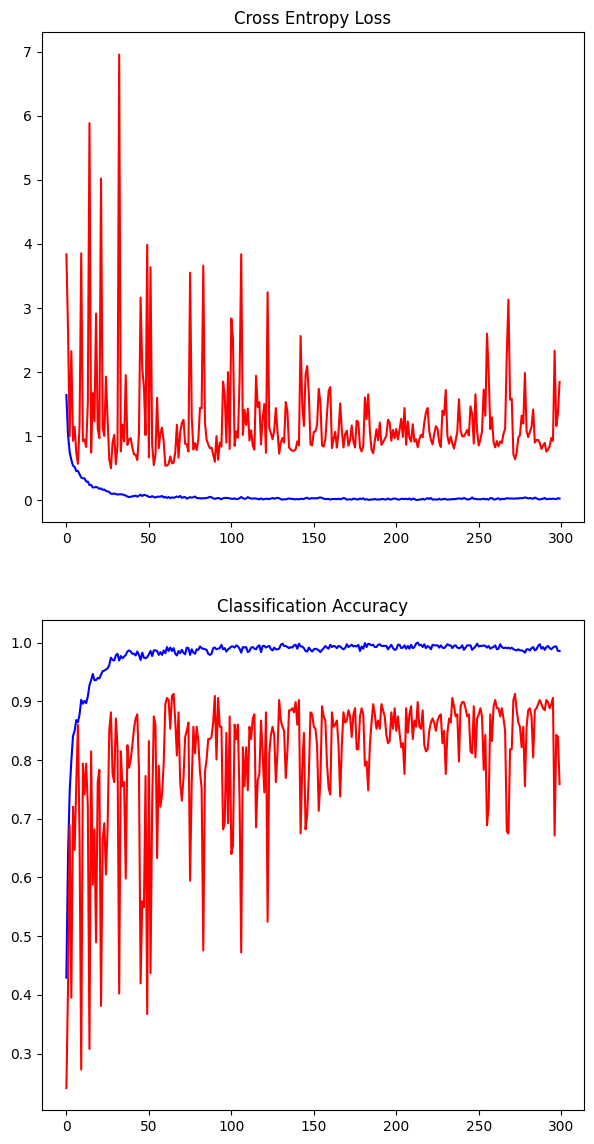

In [26]:
# plot diagnostico das curvas de loss e accuracy
def avaliacao(history,epochs):
    ''' esta função recebe os dados recolhidos no treino e as epochs para limentar o eixo x
    de segida são feitos 2 subplot, com a loss e a accuracy, respetivamente, de treino e teste'''
    epochs_array=np.arange(epochs)
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(epochs_array,history.history['loss'], color='blue', label='train')
    plt.plot(epochs_array,history.history['val_loss'], color='red', label='validation')
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(epochs_array,history.history['accuracy'], color='blue', label='train')
    plt.plot(epochs_array,history.history['val_accuracy'], color='red', label='validation')
    plt.show()

avaliacao(history,300)


- Visualização de previsões efectuadas pelo modelo treinado
para visualizar as previsões começamos por carregar e compilar o modelo pre-treinado.
De seguida, são escolhidas de forma aleatoria 14 imagens do set treino através da função escolher().
Após escolhido o set, foi definida uma função plot_prediction() que retorna a classificação de 16 letras escolhidas ao acaso com o label previsto pela reede e o label verdadeiro.  

9/9 - 0s - loss: 1.8458 - accuracy: 0.7587 - 111ms/epoch - 12ms/step
loss:  1.845794439315796  accuracy:  0.7587412595748901
1/1 [==============================] - 0s 12ms/step


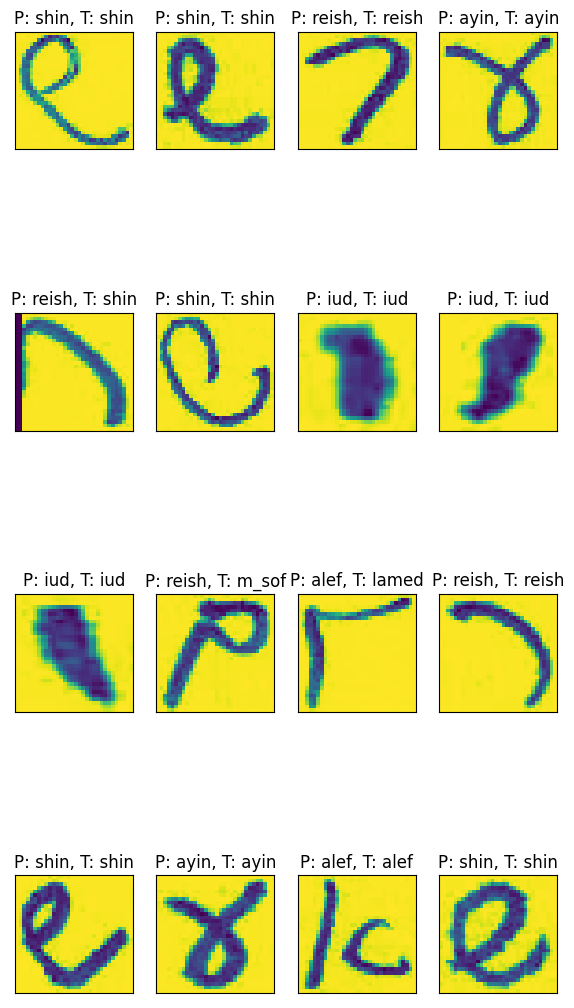

In [27]:
model_k = load_model('hebrew7_model.h5') #carregar modelo 
loss_metrics = model_k.evaluate(test_img,test_label, verbose=2) #obter loss e metrica
print('loss: ',loss_metrics[0], ' accuracy: ',loss_metrics[1])


def escolha(img):
    '''esta funcao recebe as img teste, verifica o numero de exemplares e é
    feito um random para escolher o indece para a escolha das imagens'''
    t_plot=np.random.choice(np.arange(img.shape[0]), 16,replace=False)
    return t_plot
                            
t_plot=escolha(test_img)
                          
def plot_predictions(img,true_label,t_plot):
    '''esta funcao recebe imagens aleatorias do data set teste e retorna 
    as imagens com o label verdadeirro T e o previsto P'''
    c_names=['alef','lamed','m_sof','ayin','reish','shin','iud']
    y_test=np.argmax(true_label, axis=1)
    plt.rcParams['figure.figsize'] = (7,14)
    plt.figure()
    for i in range(t_plot.shape[0]):
        indice=t_plot[i]
        plt.subplot(4,4,i+1)
        plt.imshow(img[indice].reshape(32,32))
        plt.title("P: {}, T: {}".format(c_names[argmax(model_k.predict(img[indice].reshape(1,32,32,1)))],
                                        c_names[y_test[indice]]))
        plt.xticks([])
        plt.yticks([])    
    plt.show()
    
plot_predictions(test_images,test_label,t_plot)      
    

3. Implementação de autoencoder utilizando keras functional
Neste implmentação utilizaremos o keras funcional para construir um autoencoder. O autoencoder poderia ser do tipo desnso, cnn, misto, mas como o nosso input são imagens faz sentido que o nosso autoencoder seja do tipo convulucional pois terá um melhor desempenho.
Começei por Importar funcões necessárias para edificar o modelo e que ainda não foram importadas antes.


In [28]:
from tensorflow.keras import models,layers
from tensorflow.keras.layers import UpSampling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import  Activation

- Autoencoder Conv
Para este autoencoder foi definida uma função dividida em 2 fases, na fase encoder (codificadora) farei 2 convulucoes intercaladas de 3 max-pooling. O ultimo max-pooling será o output do encoder e o input do decoder. 
O input inicial serão as imagens de treino formato (32,32) (1 camada).
Após a fase de encoder, o output terá uma representação de 4 camadas 4*4 o que prefaz um total de 68 dimensoes

Esse output será o input do deconder que tentará reproduzir a imagem dada. Ou seja, a rede tentará minimizar a entropia binária entre ambas as imagens. ou seja, o 'label' para treinar a rede será a própria imagem dada como input.
Nesse decoder serão feitas operações inversas por forma a obter de nova a dimensão de entrada, para tal em vez da utilização do pooling será utilizado o Upsampling que visa aumentar a imagem usando um tipo de interpolação (bilinear ou baseada na proximidade dos vizinhos) utilizaremos por defeito a bilinear. 
A função retorna  3 modelos, autoencoder,encoder e decoder.

In [29]:
def autoencoder_func():
    input_img = Input(shape=(32, 32, 1),name='input_img')
    # codificador
    layer = Conv2D(16, (3, 3), padding='same', activation='relu')(input_img)
    layer = MaxPooling2D(pool_size=(2,2), padding='same')(layer)
    layer = Conv2D(1,(3, 3), padding='same', activation='relu')(layer)
    encoded= MaxPooling2D(pool_size=(2,2), padding='same')(layer) #encoded
    # descodificador
    layer = Conv2D(1,(3, 3), padding='same', activation='relu')(encoded)
    layer = UpSampling2D((2, 2))(layer)
    layer = Conv2D(16,(3, 3), padding='same', activation='relu')(layer)
    layer = UpSampling2D((2, 2))(layer)
    layer = Conv2D(1,(3, 3), padding='same')(layer)
    decoded = Activation('sigmoid')(layer)
    autoencoder = Model(input_img, decoded) #modelo é estabelecido entre a layer input até ao decoded
    encoder = Model(input_img, encoded) #definir modelo considerando apenas o codificador
    decoder = Model(encoded,decoded) #definir modelo considerando apenas o descodificador
    return autoencoder,encoder,decoder

- definição,compilação e treino do modelo
Após definir as layers do modelo, definimos através do Model o input e o output. como estamos a treinar toda a rede o inputsão as imagens e o output devem ser elas mesmas, pois no final a imagem de entrada deve ser recontruida.
de seguida definimos o optimizador, neste caso optei pelo 'adam' que considera o histórico dos gradientes mas dá menos relevância aos mais antigos. é definido tambem a loss que é do tipo binário, pois estamos a comparar apenas dois valores (imagens de entrada vs img saída).

Após a compilação o modelo é treinado, defini incialmente o numero de épocas como 500, mas como verifiquei nos graficos de avaliação que a partir da época 50 não havia uma diminuição significativa da loss de test defini fazer apenas 70. Escolhi 32 exemplos para cada batch.

In [30]:
autoencoder,encoder,decoder=autoencoder_func()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')#  a afim de ser treinado, o modelo é compilado definindo as metricas e a loss, neste caso binária porque é calssificada apenas o ouput entra com o output saída 
# treinar autoencoder com as imagens de treino e imagens de teste. os 'labels' são as próprias imagens.
history_func=autoencoder.fit(train_img, train_img,
                epochs=70,
                batch_size=32,
                shuffle=True,
                validation_data=(test_img, test_img))


Epoch 1/70
33/33 [==============================] - 1s 21ms/step - loss: 0.6685 - val_loss: 0.6280
Epoch 2/70
33/33 [==============================] - 1s 18ms/step - loss: 0.5698 - val_loss: 0.5052
Epoch 3/70
33/33 [==============================] - 1s 18ms/step - loss: 0.4748 - val_loss: 0.4661
Epoch 4/70
33/33 [==============================] - 1s 19ms/step - loss: 0.4571 - val_loss: 0.4629
Epoch 5/70
33/33 [==============================] - 1s 19ms/step - loss: 0.4549 - val_loss: 0.4614
Epoch 6/70
33/33 [==============================] - 1s 19ms/step - loss: 0.4536 - val_loss: 0.4602
Epoch 7/70
33/33 [==============================] - 1s 18ms/step - loss: 0.4523 - val_loss: 0.4589
Epoch 8/70
33/33 [==============================] - 1s 19ms/step - loss: 0.4509 - val_loss: 0.4576
Epoch 9/70
33/33 [==============================] - 1s 18ms/step - loss: 0.4495 - val_loss: 0.4561
Epoch 10/70
33/33 [==============================] - 1s 18ms/step - loss: 0.4481 - val_loss: 0.4547
Epoch 11/

- Avaliação do modelo e visualização da performance
Podemos visualizar o progresso do treino, através  dos gráficos obtidos pela função abaixo definida como avaliacao(), onde é feito o plot de dois subgraficos correspondentes à perda (entropia cuzada) e à precisão do modelo para os dados de treino e teste a cada epoca.

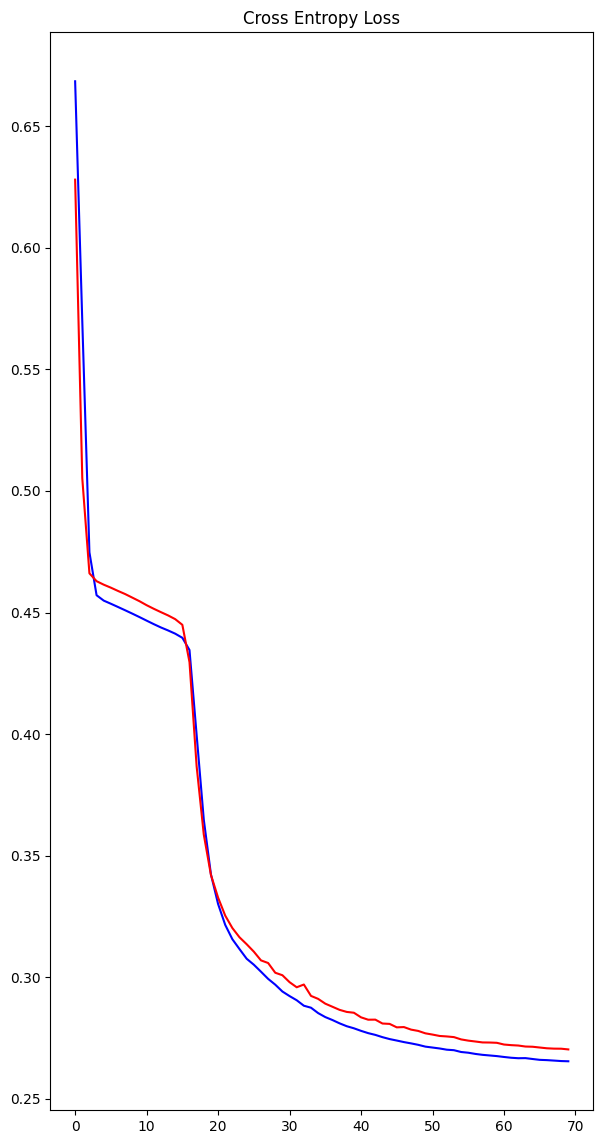

In [31]:
# plot diagnostico das curvas de loss e accuracy
def avaliacao(history,epochs):
    '''funcao recebe o histórico obtido durante o treino do modelo e retorna  os plots da loss e accuracy'''
    epochs_array=np.arange(epochs)
    # plot loss
    plt.title('Cross Entropy Loss')
    plt.plot(epochs_array,history.history['loss'], color='blue', label='train')
    plt.plot(epochs_array,history.history['val_loss'], color='red', label='test')
    plt.show()

avaliacao(history_func,70)

- Visualização dos outputs (encoded e decoder)
Por forma a fazer o plot defini uma função para escolher 7 imagens do dataset test (uma por cada classe).
Depois utilizando o maplot lib, são mostrados as imagens de test escolhidas na primeira linha.
na segunda linha é mostrado o produto obtido com o encoder.
Para tal defini que o Model do input até à layer encoded, e de seguida utilizou-se o método predict()o.
Na terceira linha é feito o plot do autoencoder, cujo o modelo foi definido anteriormente e vai da input à layer decoded, através do método predict(). 

9/9 [==============================] - 0s 2ms/step


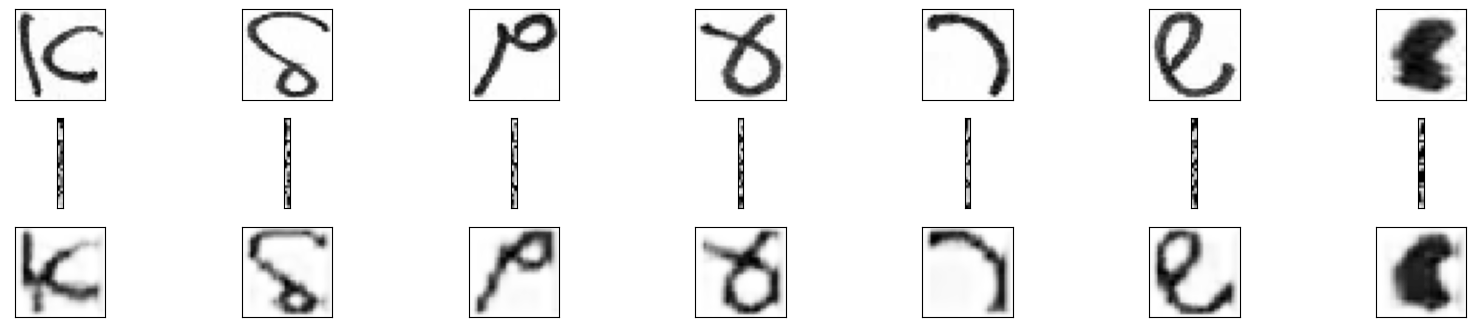

In [32]:
def data_to_plot(test_X,test_Y):
    '''funcao recebe o dataset test e retorna o
    indices de uma imagem de cada classe'''
    test_plot=[]
    label=None
    control=0
    for i in np.argmax(test_Y, axis=1):
        if i!=label:
          label=i
          test_plot.append(control+5)
          control+=1
        else:
            control+=1
    return test_plot

test_plot=data_to_plot(test_img,test_label)


decoded_imgs = autoencoder.predict(test_img) #imagens obtidas pelo decoded atraves da previsao do autoencoder
encoded_imgs = encoder.predict(test_img) #obter output do encoder apeans
        
n = 7
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    #original
    a=test_plot[i-1]
    ax = plt.subplot(3, n, i)
    plt.imshow(test_img[a].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # encoded
    ax = plt.subplot(3, n, i+n)
    plt.imshow(encoded_imgs[a].reshape((2, 2 * 16)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # reconstrução
    ax = plt.subplot(3, n, i+n+n)
    plt.imshow(decoded_imgs[a].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()